# 2020-11-27 • Factoring out windowing & averaging code

i.e. move it to codebase so it's easily reusable in next notebooks.

## Imports & time grid

In [1]:
from voltage_to_wiring_sim.support.notebook_init import *

Preloading:
 - numpy … (0.10 s)
 - matplotlib.pyplot … (0.22 s)
 - numba … (0.30 s)

Importing from submodules (compiling numba functions) … ✔

Imported `np`, `mpl`, `plt`
Imported codebase (`voltage_to_wiring_sim`) as `v`
Imported `*` from `v.support.units`
Setup autoreload


In [10]:
v.print_reproducibility_info()

This cell was last run by `tfiers` on `yoga`<br>on **Fri 27 Nov** 2020, at 10:28 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/22989fc8284b89047eedb77266cd872bce5c57d8
) (Fri 27 Nov 2020, 10:27).

Uncommited changes to:
```
A  notebooks/2020-11-11__unitlib.ipynb
?? notebooks/2020-11-27__factor_out_STA.ipynb
```

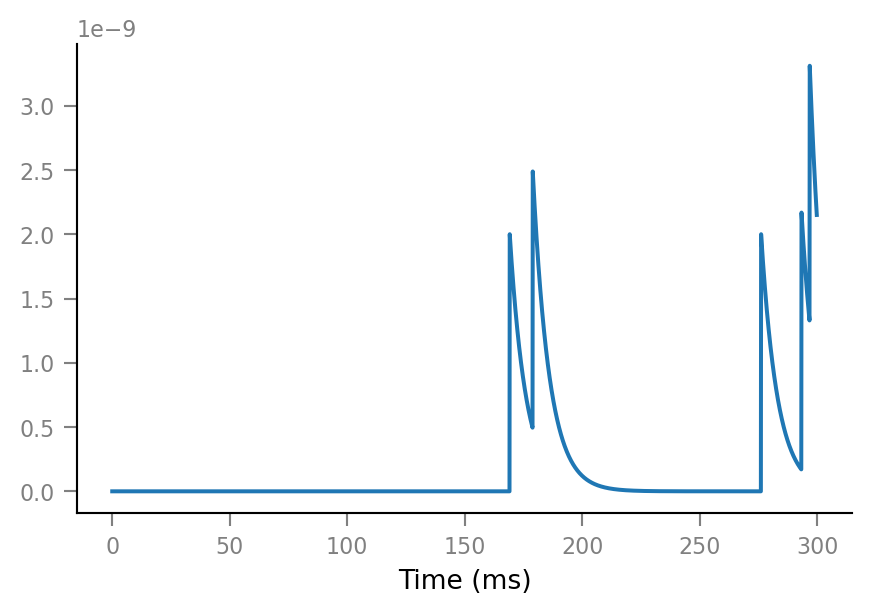

In [11]:
v.synapses.test()

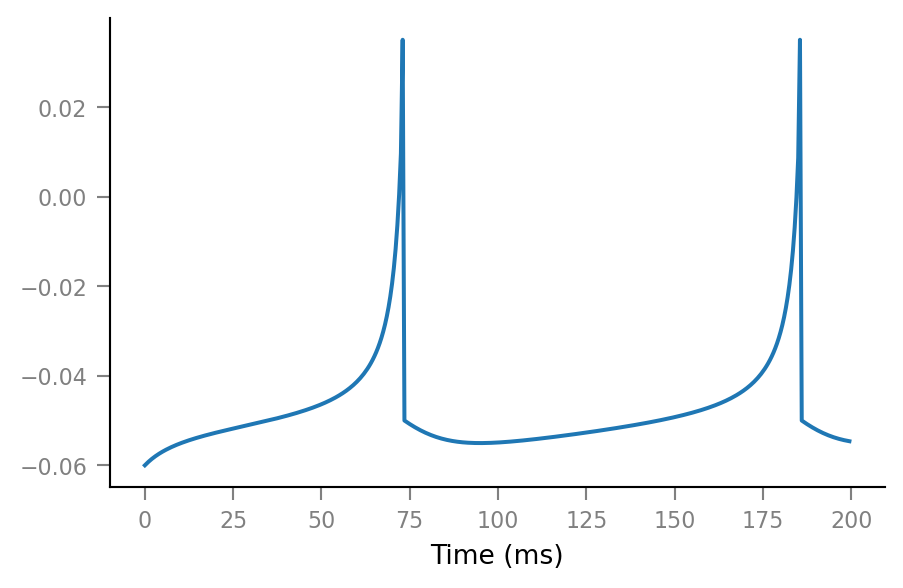

In [12]:
v.neuron_sim.test()

In [13]:
tg = v.TimeGrid(T=10*minute, dt=0.1*ms);

## Spike trains

'Network' definition.

In [14]:
N_in = 30
p_connected = 0.5

N_connected = round(N_in * p_connected)
N_unconnected = N_in - N_connected

15

Have all incoming neurons spike with the same mean frequency, for now.

In [15]:
f_spike = 20 * Hz;

In [16]:
gen_st = v.generate_Poisson_spike_train

v.fix_rng_seed()

In [17]:
%%time
spike_trains_connected = [gen_st(tg, f_spike) for _ in range(N_connected)]
spike_trains_unconnected = [gen_st(tg, f_spike) for _ in range(N_unconnected)];

Wall time: 1.55 s


This takes a while.\
Most time is spent in numpy's `random()`, which is a highly optimized function. Ergo, the implementation of the algorithm is not to blame.

We could cache spike trains.

Or, we could maybe directly generate spike times (instead of looping over all timebins), with sampling from `uniform(0, T)`. This should also generate Poisson spike trains, no? #todo: check

In [18]:
all_spike_trains = spike_trains_connected + spike_trains_unconnected;

Inspect a time excerpt..

In [30]:
time_slice = 1 * minute + np.array([0, 1]) * second

slice_indices = np.round(time_slice / tg.dt).astype(int)
i_slice = slice(*slice_indices)
t_slice = tg.t[i_slice]

array([60, 60, 60, ..., 61, 61, 61])

..of one presynaptic neuron:


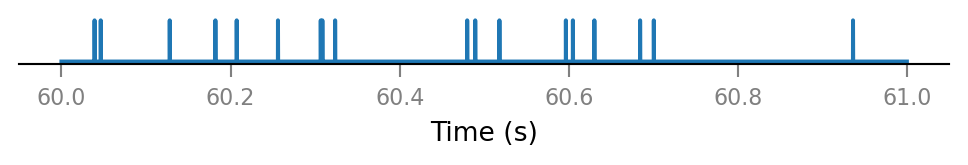

In [32]:
v.spike_train.plot(t_slice, all_spike_trains[0][i_slice]);

All connected presynaptic neurons:

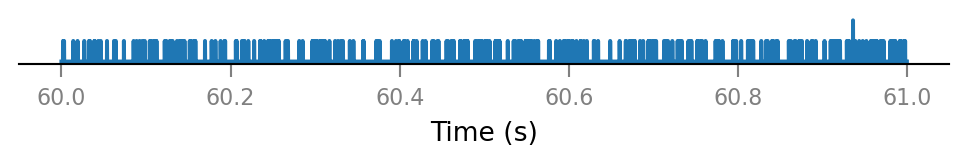

In [35]:
all_incoming_spikes = sum(spike_trains_connected)

v.spike_train.plot(t_slice, all_incoming_spikes[i_slice]);

Note that some time bins contain more than one spike.\
(The simulator handles this, by increasing synaptic conductance by an integer multiple of `Δg_syn` in that timebin).

## Synaptic conductance

See the previous notebook {doc}`/notebooks/2020-07-27__Synaptic_conductances` for some more explanation.

In [36]:
Δg_syn = 0.8 * nS
τ_syn = 7 * ms;

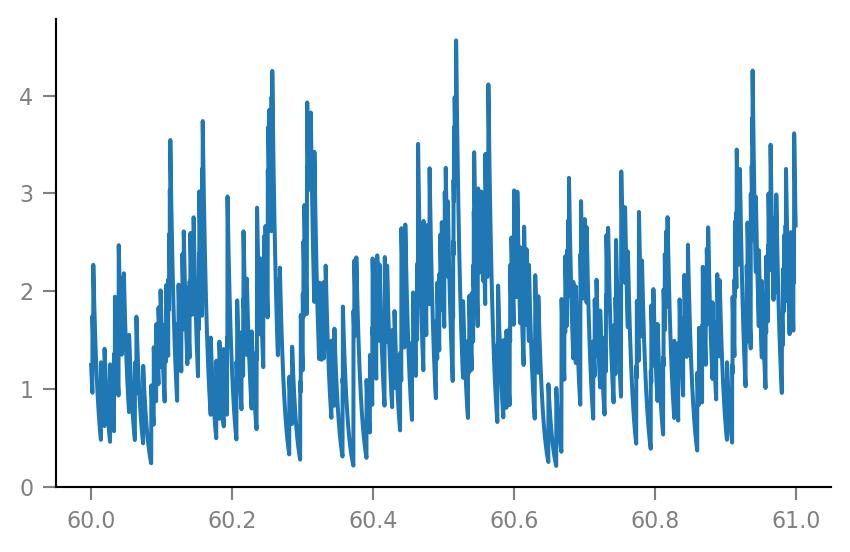

In [44]:
g_syn = v.calc_synaptic_conductance(
    tg, all_incoming_spikes, Δg_syn, τ_syn)

plt.plot(t_slice, g_syn[i_slice] / nS);

## Membrane voltage

In [41]:
params = v.params.cortical_RS
v.pprint(params)

IzhikevichParams
----------------
C = 1e-10
k = 7e-07
v_r = -0.06
v_t = -0.04
v_peak = 0.035
a = 30.0
b = -2e-09
c = -0.05
d = 1e-10
v_syn = 0.0


In [42]:
%%time
sim = v.simulate_izh_neuron(tg, params, g_syn)

Wall time: 220 ms


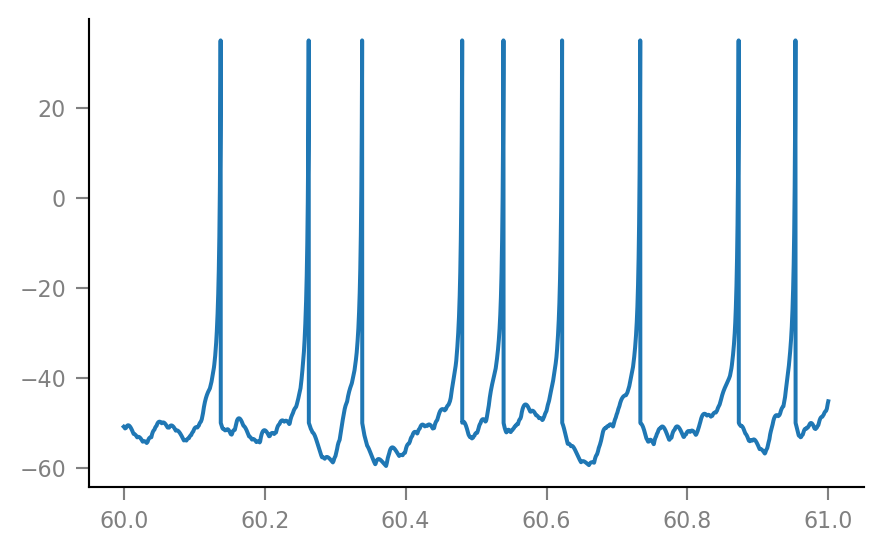

In [45]:
plt.plot(t_slice, sim.V_m[i_slice] / mV);

## Noise

As in {doc}`/notebooks/2020-07-06__Single_neuron_sim`.

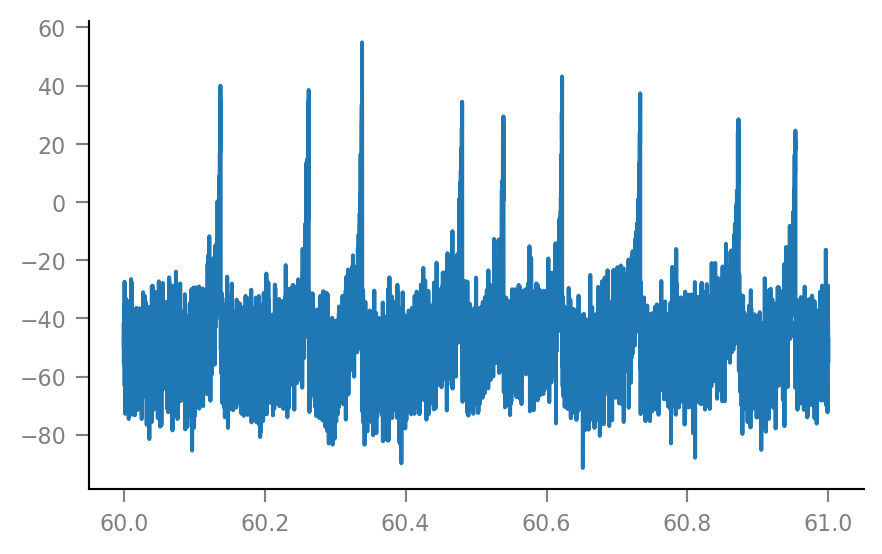

In [80]:
Vm_noisy = v.add_VI_noise(sim.V_m, params)

plt.plot(t_slice, Vm_noisy[i_slice] / mV);

## Spike-triggered windows

In [87]:
spike_train__example = all_spike_trains[0]
spike_indices__example = v.get_spike_indices(spike_train__example)
num_spikes__example = len(spike_indices__example)

12020

Spiking frequency for this presynaptic neuron:

In [84]:
num_spikes__example / tg.T / Hz

20.033333333333335

That's to spec.

Extract windows from the VI signal.

In [88]:
window_length = 100 * ms

window_tg = v.TimeGrid(window_length, tg.dt);

In [92]:
windows__example = v.make_windows(Vm_noisy, spike_indices__example, tg, window_tg)
windows__example.shape

(12019, 1000)

Note that there are generally a few less windows than spikes. This happens when the last few spikes occur too close to the end of the simulation to fit complete windows after them.

An example spike-triggered window:

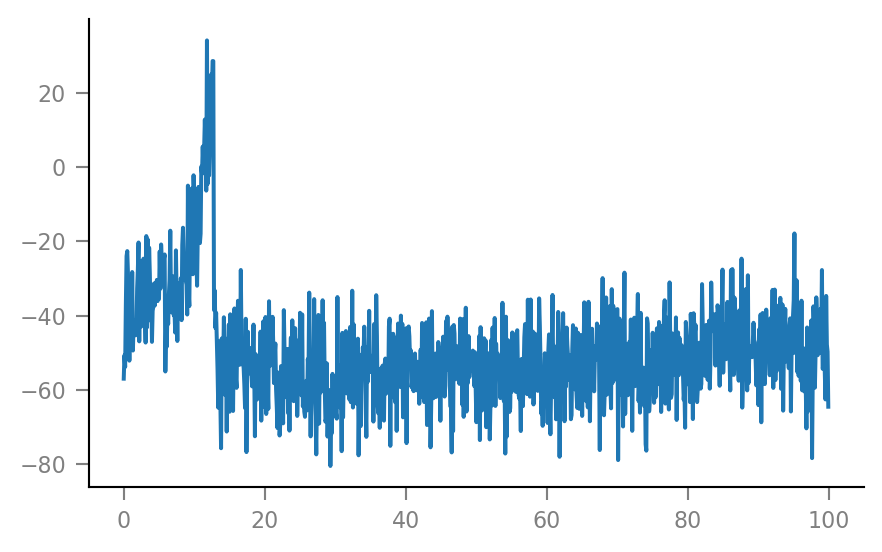

In [93]:
plt.plot(window_tg.t / ms, windows__example[0,:] / mV);

And some more:

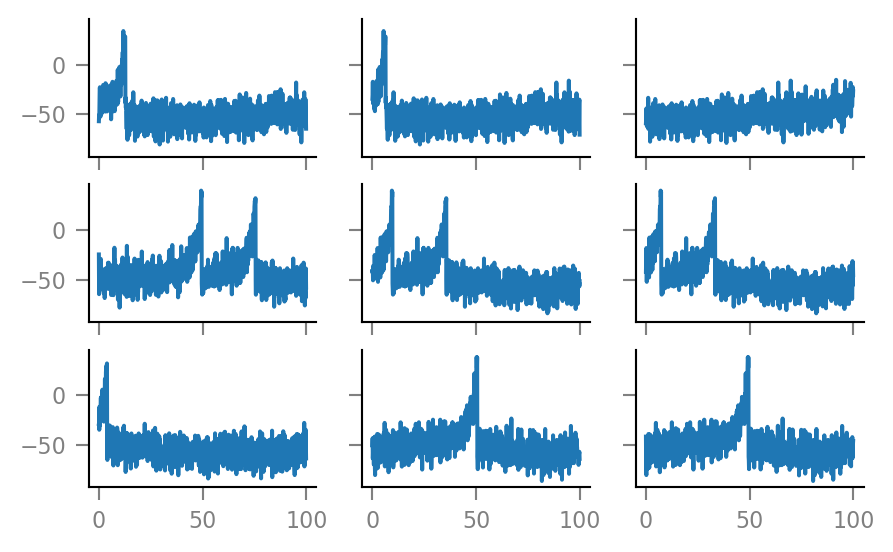

In [94]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)

for row, row_axes in enumerate(axes):
    for col, ax in enumerate(row_axes):
        i = 3*row + col
        ax.plot(window_tg.t / ms, windows__example[i,:] / mV)
        if not(row == 2 and col == 0):
            ax.set(xlabel=None, ylabel=None)

Note that the windows overlap considerably. (We see the same postsynaptic spikes here multiple times).

This is to be expected, as the mean time between a presynaptic spike..

In [95]:
(1 / f_spike) / ms

50.0

.. is shorter than the window length.

In [96]:
print(window_length / ms)

100.0


## Average windows

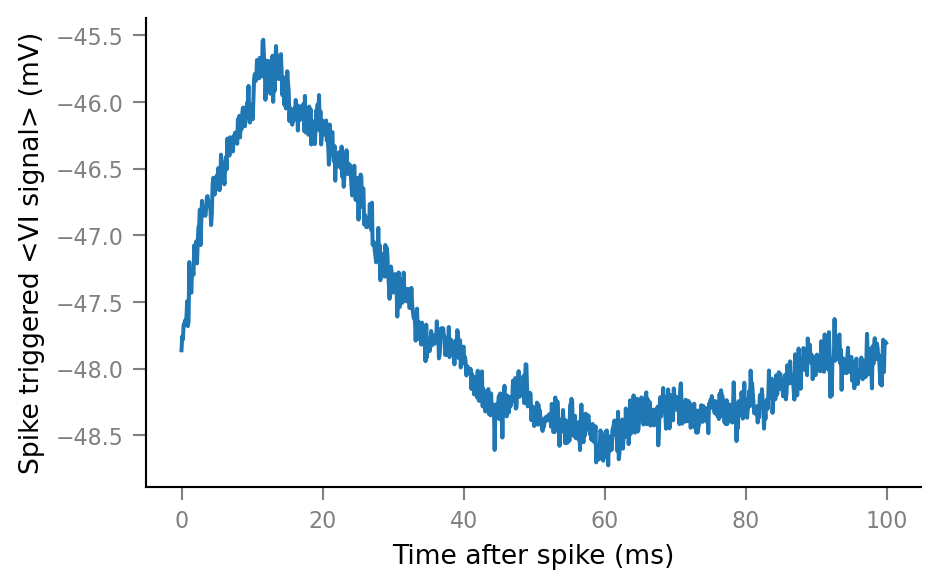

In [103]:
v.plot_STA(Vm_noisy, spike_trains_connected[0], tg, window_tg);

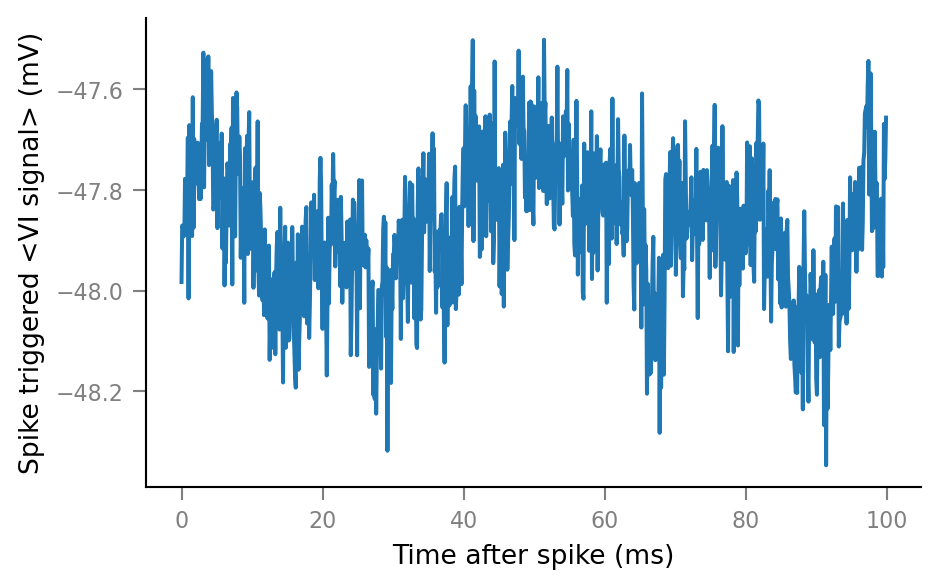

In [105]:
v.plot_STA(Vm_noisy, spike_trains_unconnected[0], tg, window_tg);

## Plot average windows of all spike trains

In [106]:
%%time

fig, ax = plt.subplots()

for spike_train in spike_trains_connected:
    plot_STA(spike_train, ax, alpha=0.2, color='C0')

for spike_train in spike_trains_unconnected:
    plot_STA(spike_train, ax, alpha=0.2, color='C1')
    
plt.close()

Wall time: 2.48 s


(Again, takes a while. Might possibly be sped up using [LineCollection](https://matplotlib.org/3.1.1/api/collections_api.html#matplotlib.collections.LineCollection)).

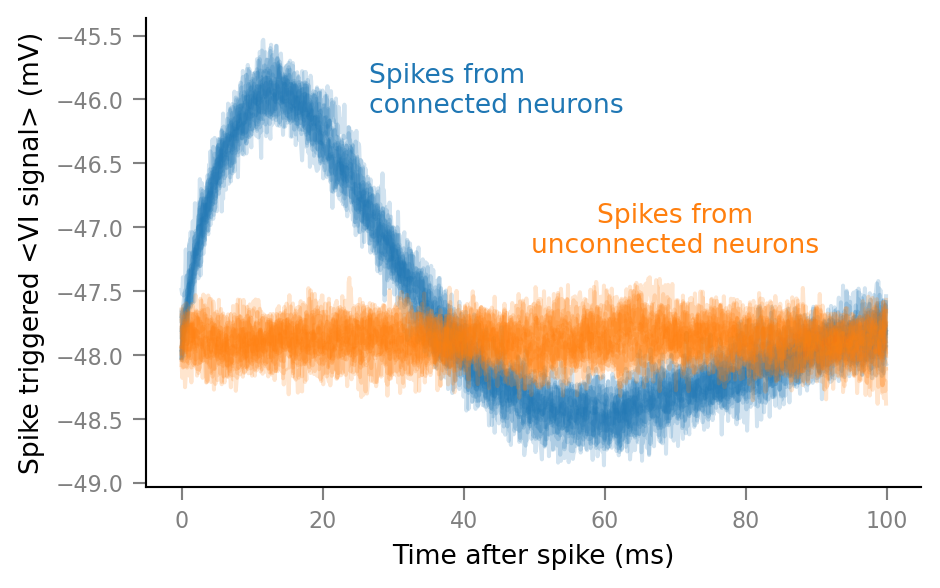

In [107]:
# Clear existing texts, for iterative positioning.
for _ in range(len(ax.texts)):
    ax.texts.pop()

ax.annotate("Spikes from\nconnected neurons",
            xy=(26.55*ms/ms, 0.8), xycoords=('data', 'axes fraction'),
            color="C0", ha="left")

ax.annotate("Spikes from\nunconnected neurons",
            xy=(70*ms/ms, 0.5), xycoords=('data', 'axes fraction'),
            color="C1", ha="center")

fig

Next steps: describe influence of `N_in`, `p_connected`, `SNR`, ..